In [9]:
%pip install pandas matplotlib seaborn sklearn torch
%pip install "numpy<2" 

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
# Load the dataset
file_path = "./bookingsSecond.csv"
df = pd.read_csv(file_path)

df = df.dropna(subset=['review_score', 'star_rating', 'is_apartment', 'breakfast_included'])

In [12]:
# Feature Engineering
df['review_score'] = df['review_score'].astype(int)
df['location_score'] = (df['location_score']).fillna(df['review_score'].mean()).astype(int)
df['is_apartment'] = (df['is_apartment']).astype(int)
df['prepayment_needed'] = (df['prepayment_needed']).astype(int)
df['breakfast_included'] = (df['breakfast_included']).astype(int)

In [13]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [14]:
df['is_weekend'] = df['checkin_date'].dt.weekday.apply(lambda x: 1 if x in [1,6,7] else 0) 
df['days_to_end_of_month'] = df['checkin_day'].apply(lambda x: 30 - x)  # Days left to the end of the month
display(df.head())

,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,is_apartment,...,breakfast_included,free_cancellation,prepayment_needed,time_to_travel,length_of_stay,snapshot_date,checkin_date,checkin_day,is_weekend,days_to_end_of_month
0,0,Iroquois New York Times Square,292,218,True,8,Very good,"2,625",5.0,0,...,1,False,1,1,1,2025-02-02,2025-02-03,3,0,27
1,1,Four Points by Sheraton New York Downtown,130,111,True,7,Good,"1,987",3.0,0,...,0,True,0,1,1,2025-02-02,2025-02-03,3,0,27
2,2,"The Mayfair Hotel Times Square, Ascend Hotel C...",141,141,False,8,Fabulous,"1,895",3.0,0,...,0,False,1,1,1,2025-02-02,2025-02-03,3,0,27
3,3,The Washington by LuxUrban,160,160,False,7,Good,"9,442",4.0,0,...,0,False,1,1,1,2025-02-02,2025-02-03,3,0,27
4,4,Hampton Inn by Hilton New York Times Square,152,152,False,7,Good,"2,432",3.0,0,...,1,False,1,1,1,2025-02-02,2025-02-03,3,0,27


In [15]:
room_type_ranking = {
    "King Room": 1,
    "Standard King Room": 2,
    "King Room - Non-Smoking": 3,
    "Queen Room": 4,
    "Double Room": 5,
    "Standard Queen Room": 6,
    "Queen Room - Non-Smoking": 7,
    "Guest Room, 1 King": 8,
    "Deluxe Queen Room": 9,
    "Deluxe King Room": 10,
    "Superior King Room": 11,
    "King Studio": 12,
    "King Room - Disability Access": 13,
    "Superior Queen Room": 14,
    "Standard Room": 15,
    "Queen Studio": 16,
    "Double Room with Two Double Beds": 17,
    "Standard Full": 18,
    "Deluxe King Room - Non-Smoking": 19,
    "Den King Room": 20,
    "Deluxe King": 21,
    "SoHo King": 22,
    "King Room with City View": 23,
    "Standard Double Room": 24,
    "Executive Queen Room": 25
}
df['room_type_grade'] = df['room_type'].map(room_type_ranking).fillna(15).astype(int)

In [16]:
# Define Features and Target
X = df[['time_to_travel', 'length_of_stay', 'prepayment_needed','review_score', 'location_score','is_apartment','breakfast_included','room_type_grade', 'days_to_end_of_month', 'is_weekend']]  # Features
y = df['discounted_price']  # Target Variable

In [17]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree depth 5': DecisionTreeRegressor(max_depth=5),
    'Decision Tree depth 10': DecisionTreeRegressor(max_depth=10),
    # 'Gaussian Process (RBF)': GaussianProcessRegressor(kernel=RBF(1.0)),
    # 'Gaussian Process (Matern)': GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5)),
    'Random Forest depth 5': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Random Forest depth 10': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting learning_rate 0.1': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'Gradient Boosting learning_rate 0.05': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    'SVR (kernel=rbf)': SVR(kernel='rbf'),
    'SVR (kernel=linear)': SVR(kernel='linear')
}

In [20]:
#Train and Evaluate Models
results = {}
for name, model_copy in models.items():
     print(f'current model: {name}')
     model_copy.fit(X_train_scaled, y_train)
     print(f'done fit: {name}')
     y_pred = model_copy.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }
     print(f'logged: {name}')

current model: Linear Regression
done fit: Linear Regression
logged: Linear Regression
current model: Decision Tree depth 5
done fit: Decision Tree depth 5
logged: Decision Tree depth 5
current model: Decision Tree depth 10
done fit: Decision Tree depth 10
logged: Decision Tree depth 10
current model: Random Forest depth 5
done fit: Random Forest depth 5
logged: Random Forest depth 5
current model: Random Forest depth 10
done fit: Random Forest depth 10
logged: Random Forest depth 10
current model: Gradient Boosting learning_rate 0.1
done fit: Gradient Boosting learning_rate 0.1
logged: Gradient Boosting learning_rate 0.1
current model: Gradient Boosting learning_rate 0.05
done fit: Gradient Boosting learning_rate 0.05
logged: Gradient Boosting learning_rate 0.05
current model: SVR (kernel=rbf)
done fit: SVR (kernel=rbf)
logged: SVR (kernel=rbf)
current model: SVR (kernel=linear)
done fit: SVR (kernel=linear)
logged: SVR (kernel=linear)


In [21]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                                            R2         MAE           MSE  \
Linear Regression                     0.660960  177.512533  69032.863302   
Decision Tree depth 5                 0.683690  175.739043  64404.774066   
Decision Tree depth 10                0.782973  135.968472  44189.400342   
Random Forest depth 5                 0.696153  168.628360  61867.134232   
Random Forest depth 10                0.790975  130.104960  42560.153972   
Gradient Boosting learning_rate 0.1   0.776391  139.694510  45529.602472   
Gradient Boosting learning_rate 0.05  0.752160  148.844303  50463.427802   
SVR (kernel=rbf)                      0.594547  180.879146  82555.338067   
SVR (kernel=linear)                   0.641379  172.282277  73019.891019   

                                            RMSE  
Linear Regression                     262.741058  
Decision Tree depth 5                 253.780957  
Decision Tree depth 10                210.212750  
Random Forest depth 5              

In [22]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

In [23]:
def display_feature_importance(model_name):
    model_copy = models[model_name]
    importance = model_copy.feature_importances_
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

In [24]:
def display_permutation_importance(model_name):
    model_copy = models[model_name]
    result = permutation_importance(model_copy, X_test_scaled, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean

    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

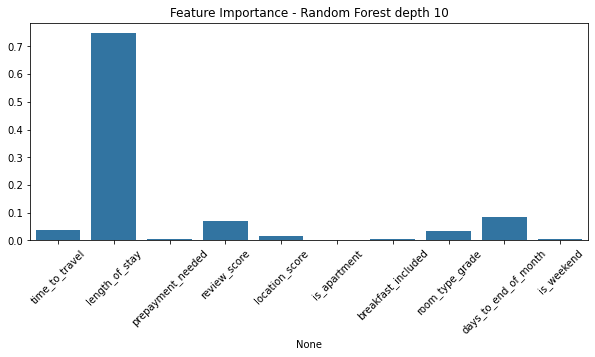

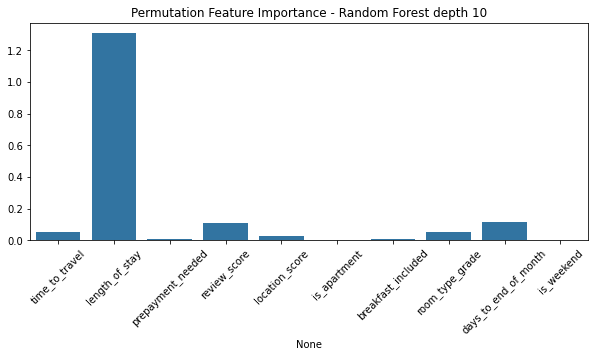

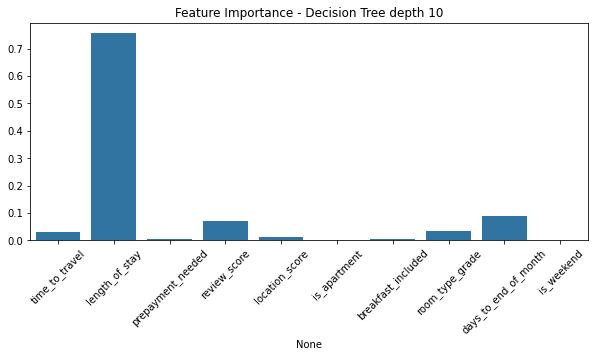

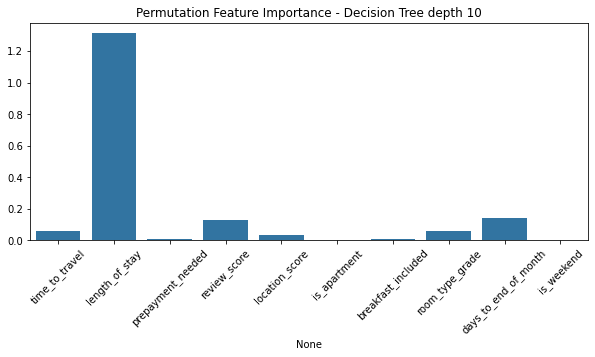

In [25]:
best_models = results_df['R2'].nlargest(2)
display_feature_importance(best_models.index[0])
display_permutation_importance(best_models.index[0])
display_feature_importance(best_models.index[1])
display_permutation_importance(best_models.index[1])

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


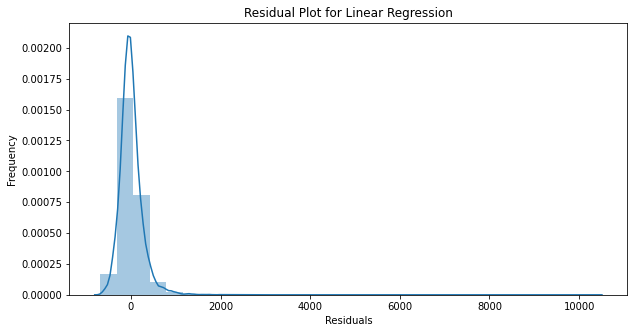

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


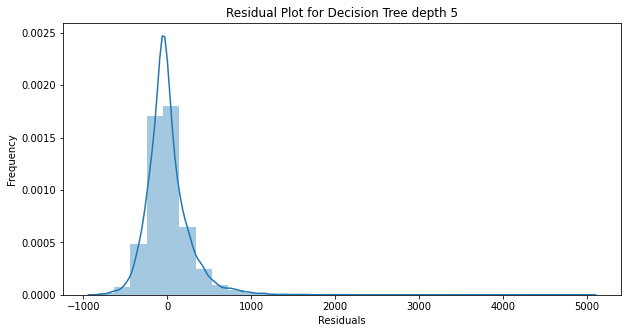

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


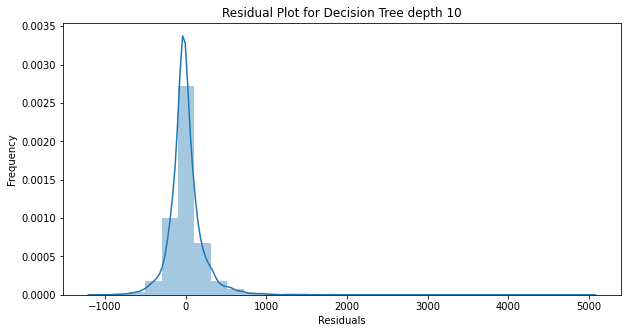

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


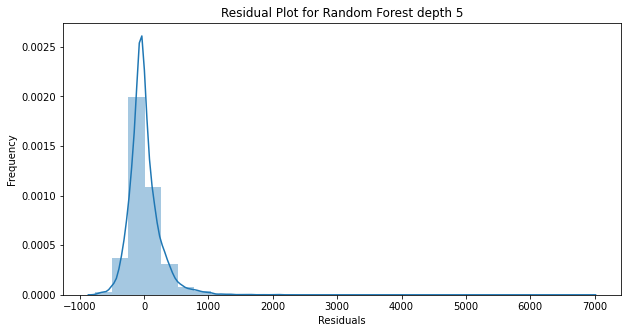

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


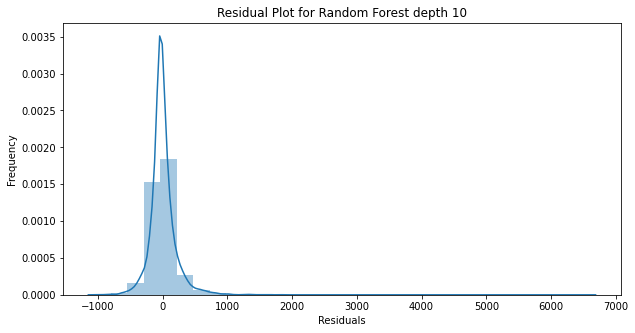

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


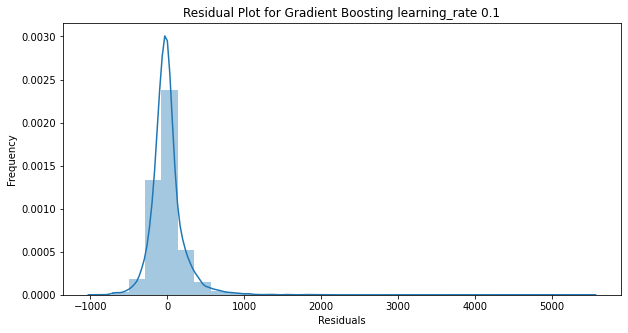

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


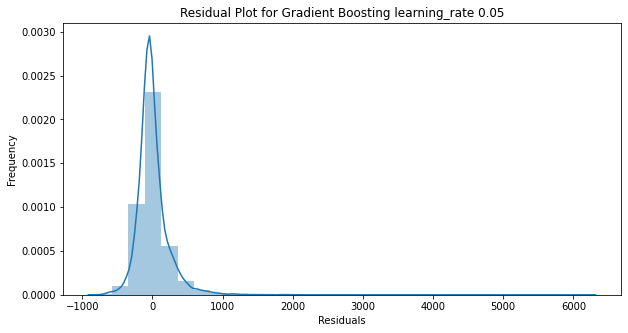

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


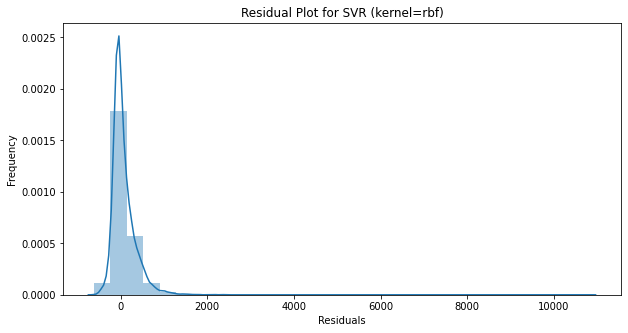

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1583615776.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


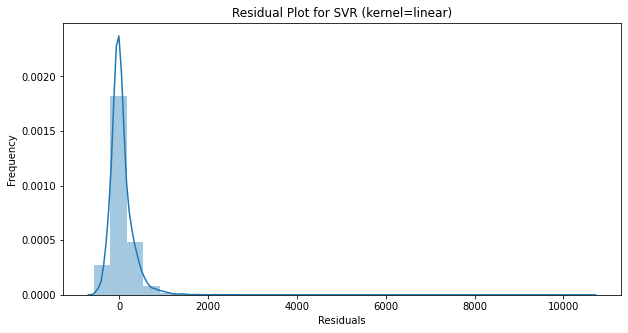

In [26]:
for name, model_copy in models.items():
    y_pred = model_copy.predict(X_test_scaled)
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 5))
    sns.distplot(residuals, bins=30, kde=True)
    plt.title(f'Residual Plot for {name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

C:\Users\Ilai\AppData\Local\Temp/ipykernel_19956/1404117669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


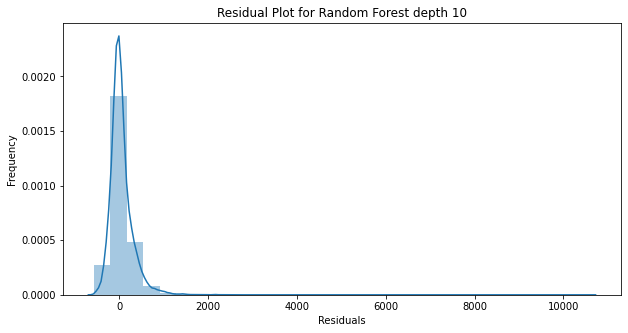

In [27]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



In [28]:
# # Feature Importance for Decision Tree and Random Forest
# for model_name in ['Decision Tree', 'Random Forest']:
#     model = models[model_name]
#     feature_importance = model.feature_importances_
#     plt.figure(figsize=(8, 4))
#     sns.barplot(x=X.columns, y=feature_importance)
#     plt.title(f'Feature Importance - {model_name}')
#     plt.show()

In [29]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Neural Network Model 1
class NeuralNet1(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural Network Model 2 with Embedding
class NeuralNet2(nn.Module):
    def __init__(self, input_dim, embedding_dim=5):
        super(NeuralNet2, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.tanh(self.embedding(x))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train NeuralNet1
model1 = NeuralNet1(X_train_scaled.shape[1])
train_model(model1, train_loader, test_loader)

# Train NeuralNet2
model2 = NeuralNet2(X_train_scaled.shape[1])
train_model(model2, train_loader, test_loader)


Epoch 1/50, Validation Loss: 69048.1129
Epoch 2/50, Validation Loss: 67749.5932
Epoch 3/50, Validation Loss: 67016.7949
Epoch 4/50, Validation Loss: 66542.5374
Epoch 5/50, Validation Loss: 65798.7243
Epoch 6/50, Validation Loss: 64719.1519
Epoch 7/50, Validation Loss: 63335.5622
Epoch 8/50, Validation Loss: 62121.6948
Epoch 9/50, Validation Loss: 60535.8646
Epoch 10/50, Validation Loss: 59840.0617
Epoch 11/50, Validation Loss: 58977.5062
Epoch 12/50, Validation Loss: 58566.2931
Epoch 13/50, Validation Loss: 58450.3193
Epoch 14/50, Validation Loss: 57902.2299
Epoch 15/50, Validation Loss: 57448.9127
Epoch 16/50, Validation Loss: 57512.4385
Epoch 17/50, Validation Loss: 56614.0919
Epoch 18/50, Validation Loss: 56609.8235
Epoch 19/50, Validation Loss: 56225.1200
Epoch 20/50, Validation Loss: 55620.9683
Epoch 21/50, Validation Loss: 56089.9874
Epoch 22/50, Validation Loss: 55319.4713
Epoch 23/50, Validation Loss: 54682.4959
Epoch 24/50, Validation Loss: 54175.5443
Epoch 25/50, Validation L

In [30]:
# from sklearn.model_selection import cross_val_score

# for name, model in models.items():
#     cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
#     print(f"{name}: {cv_scores.mean()}")

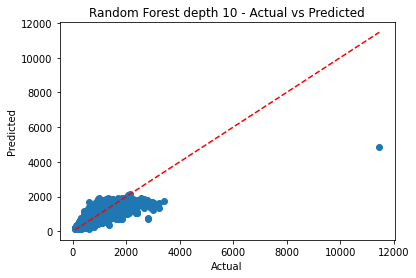

In [31]:
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'{best_model_name} - Actual vs Predicted')
plt.show()

In [32]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
    
    # Scatter plot: Predictions vs Actual
    plt.figure()
    plt.scatter(y_test.numpy(), y_pred, alpha=0.5, color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')  # Identity line
    plt.show()

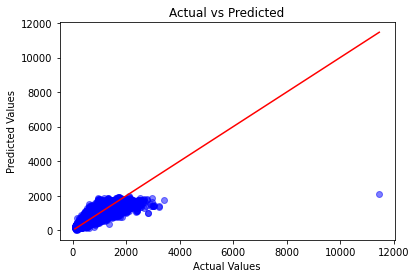

In [33]:
evaluate_model(model1, X_test_tensor, y_test_tensor)

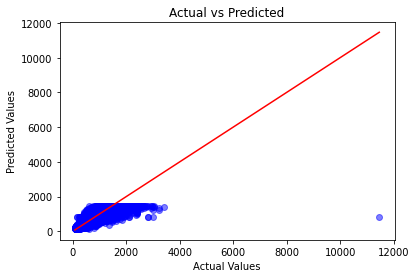

In [34]:
evaluate_model(model2, X_test_tensor, y_test_tensor)

In [35]:
X_train_25, X_test_25 = X[X['time_to_travel'] <= 25], X[X['time_to_travel'] > 25]
y_train_25, y_test_25 = y[X['time_to_travel'] <= 25], y[X['time_to_travel'] > 25]

# Re-train the best model and test
best_model.fit(X_train_25, y_train_25)
y_pred_25 = best_model.predict(X_test_25)

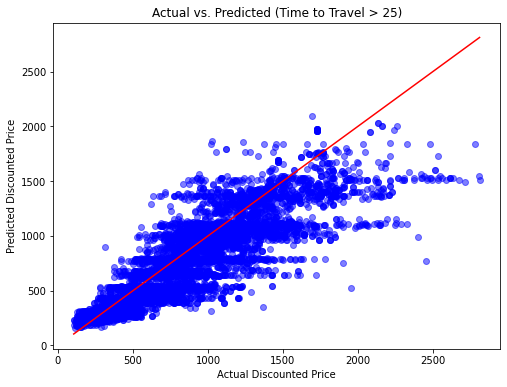

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_25, y_pred_25, alpha=0.5, color='blue')
plt.plot([y_test_25.min(), y_test_25.max()], [y_test_25.min(), y_test_25.max()], 'r')  # Identity line
plt.xlabel('Actual Discounted Price')
plt.ylabel('Predicted Discounted Price')
plt.title('Actual vs. Predicted (Time to Travel > 25)')
plt.show()